In [1]:
import pandas as pd
import numpy as np 
import math
import sys

from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

import importlib
import smlmodule

from itertools import combinations
from pprint import pprint

"""
https://bmjopen.bmj.com/content/10/9/e039338

We have computed the number of COVID-19 infected people for each province and the infection 
rate based on the number of inhabitants from February 24th to March 13th (the date when the 
lockdown was decided), as reported by the official government website, updated with daily 
frequency.34 The number of PM exceedances were computed between February 9th and February 29th, 
as we had to take into account the maximum lag period of 14 days, which is the average time 
elapsed between the contagion and the first weeks of the Italian epidemic 
(February 24th to March 13th). 

period1 = ['2020-02-09', '2020-02-28'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-24', '2020-03-13']

period2 = ['2020-02-09', '2020-03-06] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-02-09', '2020-03-21']
period3 = ['2020-08-29', '2020-09-01'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-10-15']
period4 = ['2020-08-29', '2020-10-30'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-09-12', '2020-11-14']
period5 = ['2020-05-15', '2020-08-15'] # YEAR-MONTH-DAY --->>> CASI COVID ['2020-06-01', '2020-09-01']
"""


LIMIT = 0.80

verbose = False
paperpath = "./data/particulate.csv"
agefeatspath = "./data/provinceages.csv"
deprividxpath = "./data/ID11_prov21.xlsx"
tabellecodicipath = "./data/TabelleCodici.xlsx"
copernicopath = "./data/name_region_province_statistics_2020.csv"

__provmaps__ = {
    "bolzano_bozen": "bolzano",
    "bolzanobozen": "bolzano",
    "vibovalentia": "vibo_valentia",
    "laquila": "l_aquila",
    "laspezia": "la_spezia",
    "barlettaandriatrani": "bat",
    "ascolipiceno": "ascoli_piceno",
    "carboniaiglesias": "carbonia",
    "reggioemilia": "reggio_nell_emilia",
    "pesarourbino": "pesaro",
    "monzabrianza": "monza",
    "reggiocalabria": "reggio_di_calabria",
    "forlicesena": "forli",
    "massacarrara": "massa",
    "verbanocusioossola": "verbania",
    "verbano_cusio_ossola": "verbania",
    "massa_carrara": "massa",
    "monza_e_della_brianza": "monza",
    "pesaro_e_urbino": "pesaro",
    "forli__cesena": "forli",
    "bolzano_/_bozen": "bolzano",
    "barletta_andria_trani": "bat",
    "sud_sardegna": "carbonia",
    "forlì_cesena": "forli"
}

pollutantsnames = "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wso2_period1_2020," +\
        "sum_wnh3_ex_q75_period1_2020," +\
        "sum_wnmvoc_ex_q75_period1_2020," +\
        "sum_wno2_ex_q75_period1_2020," +\
        "sum_wno_ex_q75_period1_2020," +\
        "sum_wpans_ex_q75_period1_2020," +\
        "sum_wpm10_ex_q75_period1_2020," +\
        "sum_wpm2p5_ex_q75_period1_2020," +\
        "sum_wo3_ex_q75_period1_2020," + \
        "sum_wco_ex_q75_period1_2020," + \
        "sum_wso2_ex_q75_period1_2020"

featurestobeused = "density," + \
        "commutersdensity," + \
        "depriv," + \
        "lat," + \
        "Ratio0200ver65," + \
        "avg_wpm10_period1_2020,"+\
        "avg_wpm2p5_period1_2020,"+\
        "avg_wco_period1_2020,"+\
        "avg_wnh3_period1_2020,"+\
        "avg_wnmvoc_period1_2020,"+\
        "avg_wno2_period1_2020,"+\
        "avg_wno_period1_2020,"+\
        "avg_wo3_period1_2020,"+\
        "avg_wpans_period1_2020,"+\
        "avg_wso2_period1_2020"

def filterprovname (inprov):
    low = inprov.lower()
    low = low.rstrip()
    low = low.lstrip()
    low = low.replace(" ", "_")
    low = low.replace("'", "_")
    low = low.replace("-", "_")

    return low

def normalize_provname (indata, provcolumn, verbose):

    dict_data = {}  
    for c in indata.columns:
        if verbose:
            print("  ", c)
        if c != provcolumn:
            dict_data[c] = []
    dict_data["prov"] = []

    for i, row in indata.iterrows():
        for c in indata.columns:    
            if c != provcolumn:
                dict_data[c].append(row[c])
            else:
                low = filterprovname(row[c])
                if low in __provmaps__:
                    low = __provmaps__[low]

                dict_data["prov"].append(low)

    #for v in dict_data:
    #    print(v, " ", len(dict_data[v]))

    data = pd.DataFrame.from_dict(dict_data)

    return data

In [2]:
tc = pd.ExcelFile(tabellecodicipath)

idtoprov = {}
province = tc.parse("Codice Provincia")
for val in province[["Codice Provincia","Nome Provincia"]].values:
    if type(val[1]) != float:
        idtoprov[int(val[0])] = val[1]
        #print(int(val[0]), val[1])

in_datapaper = pd.read_csv(paperpath, sep=";")
in_deprividx =  pd.ExcelFile(deprividxpath).parse("Foglio1")
in_agefeatures = pd.read_csv(agefeatspath)
in_agefeatures = in_agefeatures[in_agefeatures.Population2020 != 0.0]
in_copernico = pd.read_csv(copernicopath)

print("Paper data ")
datapaper = normalize_provname(in_datapaper, "Province", False)
print("Age features ")
agefeatures = normalize_provname(in_agefeatures, "Provincia", False)
print("Copernico data ") 
copernico = normalize_provname(in_copernico, "nome_ita", False)

dict_deprividx = {}
print("DrepivIdx name ")
for c in in_deprividx.columns:
    if verbose:
        print("   ", c)   
    dict_deprividx[c] = []
dict_deprividx["prov"] = []

for i, row in in_deprividx.iterrows():
    id = row["prov21"]
    prov = filterprovname(idtoprov[id])
    
    if prov in __provmaps__:
        prov = __provmaps__[prov]
    
    #print(id, prov)
    dict_deprividx["prov"].append(prov)
    for c in in_deprividx.columns:
        dict_deprividx[c].append(row[c])


deprividx = pd.DataFrame.from_dict(dict_deprividx)       

provincelist = list(set(list(datapaper["prov"].values)) & \
        set(list(deprividx["prov"].values)) & \
        set(list(agefeatures["prov"].values)) &
        set(list(copernico["prov"].values)))

print("Province list: ")
for i, p in enumerate(provincelist):
    print("  ", i+1, " ", p)

Paper data 
Age features 
Copernico data 
DrepivIdx name 
Province list: 
   1   forli
   2   napoli
   3   carbonia
   4   cremona
   5   reggio_di_calabria
   6   ragusa
   7   rieti
   8   trento
   9   pordenone
   10   gorizia
   11   la_spezia
   12   macerata
   13   brindisi
   14   roma
   15   crotone
   16   catania
   17   venezia
   18   belluno
   19   salerno
   20   siracusa
   21   pavia
   22   cagliari
   23   alessandria
   24   biella
   25   isernia
   26   pisa
   27   foggia
   28   treviso
   29   arezzo
   30   sondrio
   31   lecco
   32   vercelli
   33   latina
   34   enna
   35   vibo_valentia
   36   siena
   37   lodi
   38   trieste
   39   padova
   40   caltanissetta
   41   monza
   42   genova
   43   potenza
   44   mantova
   45   pesaro
   46   catanzaro
   47   modena
   48   novara
   49   brescia
   50   teramo
   51   massa
   52   palermo
   53   cuneo
   54   agrigento
   55   perugia
   56   verbania
   57   udine
   58   pescara
   59   

In [3]:
counter = 0

for prov in provincelist:
    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]
    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 

    #if diff < 5.0 :
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        counter += 1
        print(counter, prov)

ylogpropcasi = []
features_dict = {}

for fn in ("population", "density", "commutersdensity", "depriv", \
    "lat", "Ratio0200ver65","exoverstation"):
    features_dict[fn] = np.zeros(counter, dtype="float64")

for fn in pollutantsnames.split(","):
    features_dict[fn] = np.zeros(counter, dtype="float64")

i = 0 
for idx, prov in enumerate(provincelist):

    cases = datapaper[datapaper["prov"] == prov]["Cases"].values[0]
    popolazione = datapaper[datapaper["prov"] == prov]["Population"].values[0]
    pop2 = agefeatures[agefeatures["prov"] == prov]["Population2020"].values[0]

    diff = 100.0*(math.fabs(popolazione-pop2)/(popolazione))

    # check Exceedances/StationsNum
    Exceedances = datapaper[datapaper["prov"] == prov]["Exceedances"].values[0] 
    StationsNum = datapaper[datapaper["prov"] == prov]["StationsNum"].values[0] 
    
    ycasi = cases/popolazione

    #if diff < 5.0:
    #if cases > 0.0 and diff < 5.0 and StationsNum > 0:
    if cases > 0.0 and diff < 5.0:
        if ycasi == 0.0:
           ylogpropcasi.append(-13.0) 
        else:
            ylogpropcasi.append(math.log(ycasi)) # atural logarithm of different numbers

        selected = copernico[copernico["prov"] == prov]

        features_dict["population"][i] = popolazione
        features_dict["density"][i] = \
                    datapaper[datapaper["prov"] == prov]["Density"].values[0]    
        features_dict["commutersdensity"][i] = \
                    datapaper[datapaper["prov"] == prov]["CommutersDensity"].values[0]       
        features_dict["lat"][i] = \
                    datapaper[datapaper["prov"] == prov]["Lat"].values[0]       
        features_dict["depriv"][i] = \
                    deprividx[deprividx["prov"] == prov]["ID_2011"].values[0]
        #print(idx, prov, agefeatures[agefeatures["prov"] == prov])
        features_dict["Ratio0200ver65"][i] = \
                    agefeatures[agefeatures["prov"] == prov]["Ratio0200ver65"].values[0]

        for fn in pollutantsnames.split(","):
            val = selected[fn].values[0]
            features_dict[fn][i] = val 

        #features_dict["exoverstation"][i] = Exceedances/StationsNum


        i = i + 1

1 forli
2 napoli
3 cremona
4 reggio_di_calabria
5 ragusa
6 rieti
7 trento
8 pordenone
9 gorizia
10 la_spezia
11 macerata
12 brindisi
13 roma
14 crotone
15 catania
16 venezia
17 belluno
18 salerno
19 siracusa
20 pavia
21 cagliari
22 alessandria
23 biella
24 pisa
25 foggia
26 treviso
27 arezzo
28 sondrio
29 lecco
30 vercelli
31 latina
32 enna
33 vibo_valentia
34 siena
35 lodi
36 trieste
37 padova
38 caltanissetta
39 monza
40 genova
41 potenza
42 mantova
43 pesaro
44 catanzaro
45 modena
46 novara
47 brescia
48 teramo
49 massa
50 palermo
51 cuneo
52 agrigento
53 perugia
54 verbania
55 udine
56 pescara
57 benevento
58 reggio_nell_emilia
59 sassari
60 vicenza
61 frosinone
62 piacenza
63 l_aquila
64 chieti
65 cosenza
66 ancona
67 varese
68 terni
69 imperia
70 firenze
71 bari
72 matera
73 bat
74 trapani
75 rovigo
76 torino
77 campobasso
78 prato
79 pistoia
80 parma
81 bolzano
82 bologna
83 avellino
84 lucca
85 rimini
86 livorno
87 grosseto
88 bergamo
89 ferrara
90 oristano
91 caserta
92 milano

In [4]:
# nomalize values
new_features_dict = {}
for fn in features_dict:
    #print(fn)
    abs_max = np.amax(np.abs(features_dict[fn]))
    if abs_max == 0.0:
        print (fn, " will be removed ")
        print (features_dict[fn])
    else:
        new_features_dict[fn] = features_dict[fn] * (1.0 / abs_max)

features_dict = new_features_dict

highcorrelated = {}
for i1, v1 in enumerate(features_dict):
    highcorrelated[v1] = []
    for i2, v2 in enumerate(features_dict):
        #if v1 != v2 and i2 > i1:
        if v1 != v2:
            corr, _ = pearsonr(features_dict[v1], features_dict[v2])
            if math.fabs(corr) > LIMIT:
                highcorrelated[v1].append(v2)
                #print(v1, v2, corr)

    #if len(highcorrelated[v1]) > 0:
    #    print(v1)
    #    for fntr in highcorrelated[v1]:
    #        print("   ", fntr)

removedfeatures = []
features = []
for fn in featurestobeused.split(","):
    if fn in features_dict:
        canadd = True
        for fnin in features:
            if fn in highcorrelated[fnin]:
                canadd = False
                break

        if canadd:
            print("Using: %30s"%fn)
            features.append(fn)
        else:
            removedfeatures.append(fn)


print("")
for fn in removedfeatures:
    print("Highly correlated removing %30s"%fn)
    for cf  in highcorrelated[fn]:
        print("     ",cf)
print(" ")

exoverstation  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wo3_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
sum_wco_ex_q75_period1_2020  will be removed 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.

Training set average RMSE:  0.35630  0.02389 
    Test set average RMSE:  0.95415  0.09273 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33503
                       R2:  0.94863


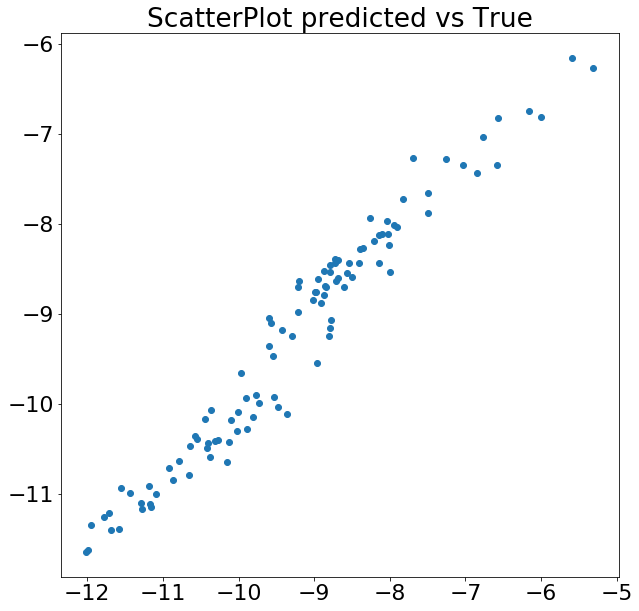

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.02997
Feature:               commutersdensity, Score: 0.01499
Feature:                         depriv, Score: 0.02672
Feature:                            lat, Score: 0.66084
Feature:                 Ratio0200ver65, Score: 0.05817
Feature:         avg_wpm10_period1_2020, Score: 0.08077
Feature:           avg_wno_period1_2020, Score: 0.07134
Feature:         avg_wpans_period1_2020, Score: 0.03053
Feature:          avg_wso2_period1_2020, Score: 0.02667


<Figure size 432x288 with 0 Axes>

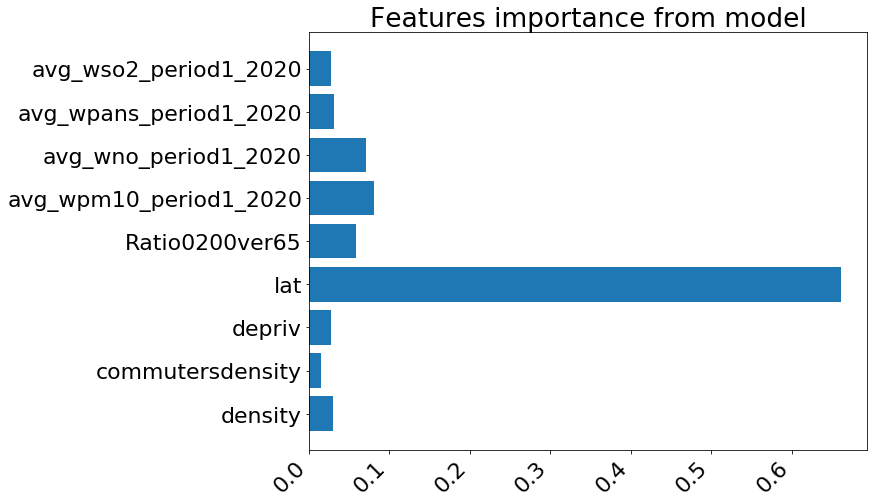

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05588 +/- 0.00596
Feature:               commutersdensity, Score: 0.02089 +/- 0.00273
Feature:                         depriv, Score: 0.05339 +/- 0.00578
Feature:                            lat, Score: 2.76879 +/- 0.38097
Feature:                 Ratio0200ver65, Score: 0.12607 +/- 0.02507
Feature:         avg_wpm10_period1_2020, Score: 0.18444 +/- 0.01844
Feature:           avg_wno_period1_2020, Score: 0.22609 +/- 0.02844
Feature:         avg_wpans_period1_2020, Score: 0.07013 +/- 0.00861
Feature:          avg_wso2_period1_2020, Score: 0.07678 +/- 0.01280


<Figure size 432x288 with 0 Axes>

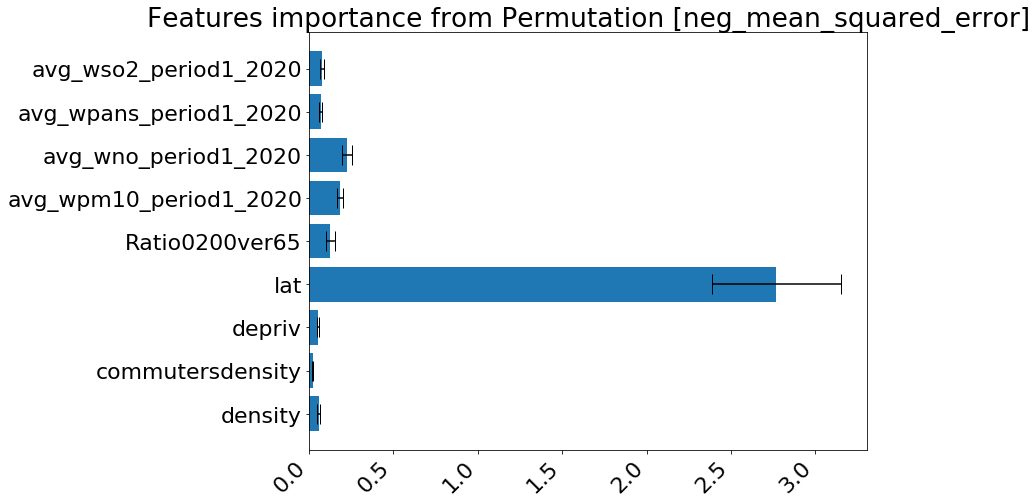

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02557 +/- 0.00273
Feature:               commutersdensity, Score: 0.00956 +/- 0.00125
Feature:                         depriv, Score: 0.02443 +/- 0.00264
Feature:                            lat, Score: 1.26704 +/- 0.17434
Feature:                 Ratio0200ver65, Score: 0.05769 +/- 0.01147
Feature:         avg_wpm10_period1_2020, Score: 0.08440 +/- 0.00844
Feature:           avg_wno_period1_2020, Score: 0.10346 +/- 0.01301
Feature:         avg_wpans_period1_2020, Score: 0.03209 +/- 0.00394
Feature:          avg_wso2_period1_2020, Score: 0.03514 +/- 0.00586


<Figure size 432x288 with 0 Axes>

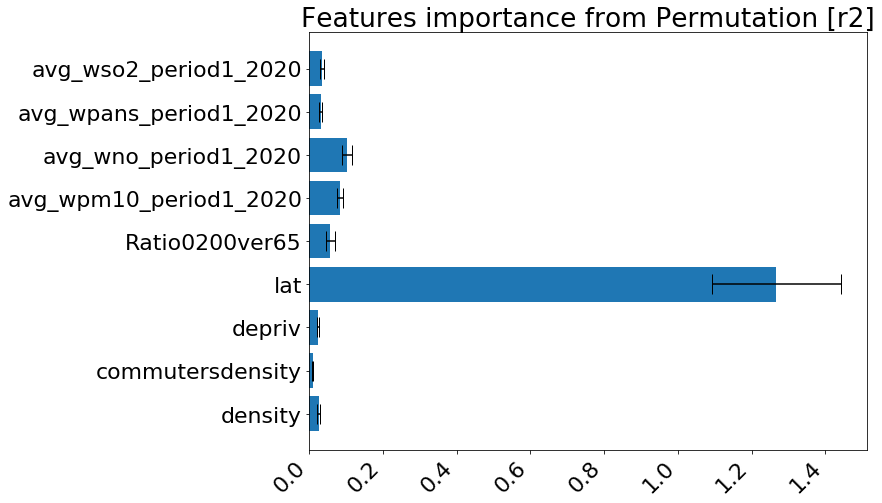

<Figure size 720x720 with 0 Axes>

((0.35629689546304205, 0.023887195273555182),
 (0.9541546177950364, 0.09272685714018795),
 0.33503401616585565,
 {'density': 0.015598026023122283,
  'commutersdensity': 0.005830477495856166,
  'depriv': 0.014903382854519382,
  'lat': 0.7728736635946812,
  'Ratio0200ver65': 0.035191806454093484,
  'avg_wpm10_period1_2020': 0.051484380775370715,
  'avg_wno_period1_2020': 0.06310931806391087,
  'avg_wpans_period1_2020': 0.019575640552714012,
  'avg_wso2_period1_2020': 0.021433304185731906},
 {'density': 0.01559802602312227,
  'commutersdensity': 0.005830477495856163,
  'depriv': 0.014903382854519368,
  'lat': 0.7728736635946812,
  'Ratio0200ver65': 0.03519180645409347,
  'avg_wpm10_period1_2020': 0.051484380775370694,
  'avg_wno_period1_2020': 0.06310931806391087,
  'avg_wpans_period1_2020': 0.019575640552713998,
  'avg_wso2_period1_2020': 0.0214333041857319})

In [5]:
#finalfeaturestobeused = "density,commutersdensity,exoverstation"
#features = finalfeaturestobeused.split(",")
#listostack = [features_dict[v] for v in features]
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures", showplot=True)

In [6]:
importlib.reload(smlmodule)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.11224779198822282
2  of  1200 MSE:  0.11407534909056247
3  of  1200 MSE:  0.171444016372523
4  of  1200 MSE:  0.2084913866519744
5  of  1200 MSE:  0.4050488414439886
6  of  1200 MSE:  0.47567902335088963
7  of  1200 MSE:  0.5918205312022169
8  of  1200 MSE:  0.6534704048603545
9  of  1200 MSE:  0.16632914524186296
10  of  1200 MSE:  0.1946518242278785
11  of  1200 MSE:  0.19413289426347352
12  of  1200 MSE:  0.23192842964630825
13  of  1200 MSE:  0.4050488414439886
14  of  1200 MSE:  0.47567902335088963
15  of  1200 MSE:  0.5918205312022169
16  of  1200 MSE:  0.6534704048603545
17  of  1200 MSE:  0.2744892349424922
18  of  1200 MSE:  0.3259907052291079
19  of  1200 MSE:  0.3007447986388564
20  of  1200 MSE:  0.35445567494377916
21  of  1200 MSE:  0.4050488414439886
22  of  1200 MSE:  0.47567902335088963
23  of  1200 MSE:  0.5918205312022169
24  of  1200 MSE:  0.6534704048603545
25  of  1200 MSE:  0.3812940035567047
26  of  1200 MSE:  0.42888621475809824
27  of  1200

{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200,
 'random_state': 1}
Training set average RMSE:  0.34246  0.01822 
    Test set average RMSE:  0.94591  0.08616 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.33281
                       R2:  0.94931


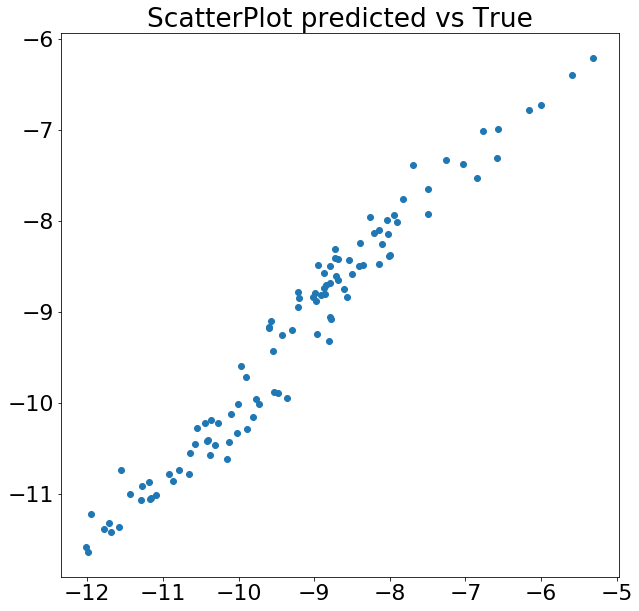

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.04005
Feature:               commutersdensity, Score: 0.17124
Feature:                         depriv, Score: 0.09480
Feature:                            lat, Score: 0.29684
Feature:                 Ratio0200ver65, Score: 0.06245
Feature:         avg_wpm10_period1_2020, Score: 0.12063
Feature:           avg_wno_period1_2020, Score: 0.12876
Feature:         avg_wpans_period1_2020, Score: 0.03656
Feature:          avg_wso2_period1_2020, Score: 0.04867


<Figure size 432x288 with 0 Axes>

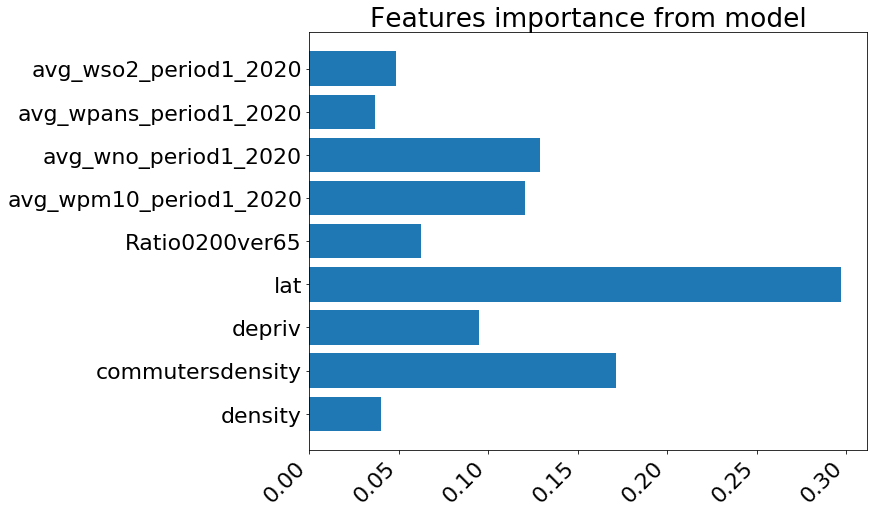

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.05503 +/- 0.00639
Feature:               commutersdensity, Score: 0.02654 +/- 0.00320
Feature:                         depriv, Score: 0.05485 +/- 0.00587
Feature:                            lat, Score: 2.73222 +/- 0.37543
Feature:                 Ratio0200ver65, Score: 0.10646 +/- 0.01832
Feature:         avg_wpm10_period1_2020, Score: 0.21081 +/- 0.02227
Feature:           avg_wno_period1_2020, Score: 0.19894 +/- 0.02328
Feature:         avg_wpans_period1_2020, Score: 0.05846 +/- 0.00737
Feature:          avg_wso2_period1_2020, Score: 0.08001 +/- 0.01498


<Figure size 432x288 with 0 Axes>

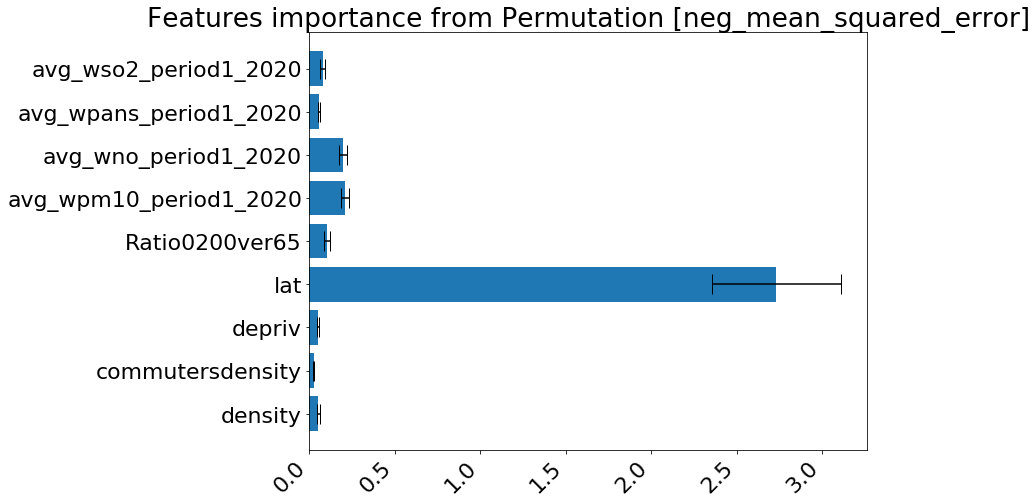

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02518 +/- 0.00292
Feature:               commutersdensity, Score: 0.01214 +/- 0.00146
Feature:                         depriv, Score: 0.02510 +/- 0.00269
Feature:                            lat, Score: 1.25030 +/- 0.17180
Feature:                 Ratio0200ver65, Score: 0.04872 +/- 0.00839
Feature:         avg_wpm10_period1_2020, Score: 0.09647 +/- 0.01019
Feature:           avg_wno_period1_2020, Score: 0.09104 +/- 0.01065
Feature:         avg_wpans_period1_2020, Score: 0.02675 +/- 0.00337
Feature:          avg_wso2_period1_2020, Score: 0.03662 +/- 0.00685


<Figure size 432x288 with 0 Axes>

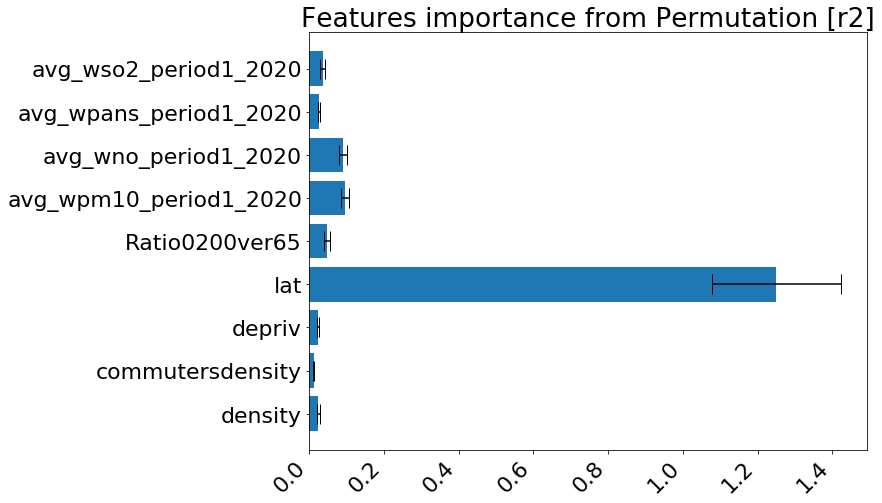

<Figure size 720x720 with 0 Axes>

((0.34245557720706477, 0.01821970048153239),
 (0.9459072905224748, 0.08616130594487931),
 0.33280680683753694,
 {'density': 0.015618040061862869,
  'commutersdensity': 0.007531525133507977,
  'depriv': 0.015566901138521506,
  'lat': 0.7754687575461736,
  'Ratio0200ver65': 0.030215798330784693,
  'avg_wpm10_period1_2020': 0.059832912048182724,
  'avg_wno_period1_2020': 0.05646521637423369,
  'avg_wpans_period1_2020': 0.01659106898333198,
  'avg_wso2_period1_2020': 0.022709780383401133},
 {'density': 0.015618040061862846,
  'commutersdensity': 0.0075315251335079545,
  'depriv': 0.01556690113852148,
  'lat': 0.7754687575461736,
  'Ratio0200ver65': 0.03021579833078467,
  'avg_wpm10_period1_2020': 0.05983291204818271,
  'avg_wno_period1_2020': 0.05646521637423367,
  'avg_wpans_period1_2020': 0.016591068983331958,
  'avg_wso2_period1_2020': 0.022709780383401105})

In [7]:
pprint(bestf)

featuresused = features

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_allfeatures_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.38850  0.02998 
    Test set average RMSE:  1.00552  0.12231 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.35814
                       R2:  0.94131


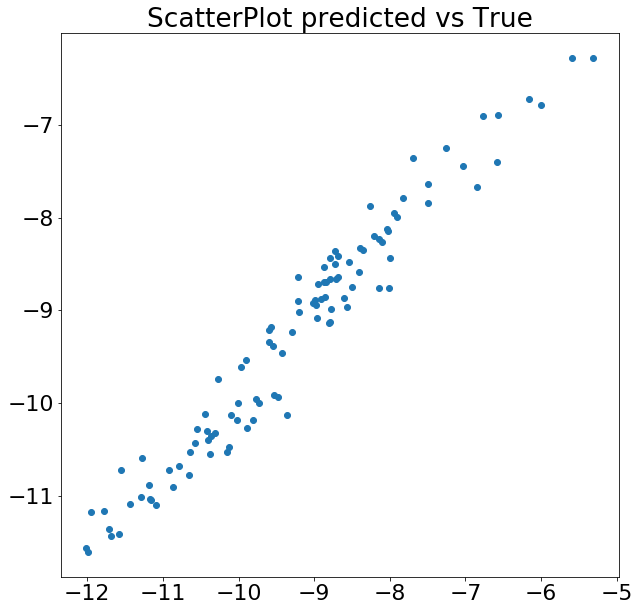

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03594
Feature:               commutersdensity, Score: 0.50563
Feature:                         depriv, Score: 0.03727
Feature:                 Ratio0200ver65, Score: 0.09618
Feature:         avg_wpm10_period1_2020, Score: 0.10763
Feature:           avg_wno_period1_2020, Score: 0.12888
Feature:         avg_wpans_period1_2020, Score: 0.03824
Feature:          avg_wso2_period1_2020, Score: 0.05023


<Figure size 432x288 with 0 Axes>

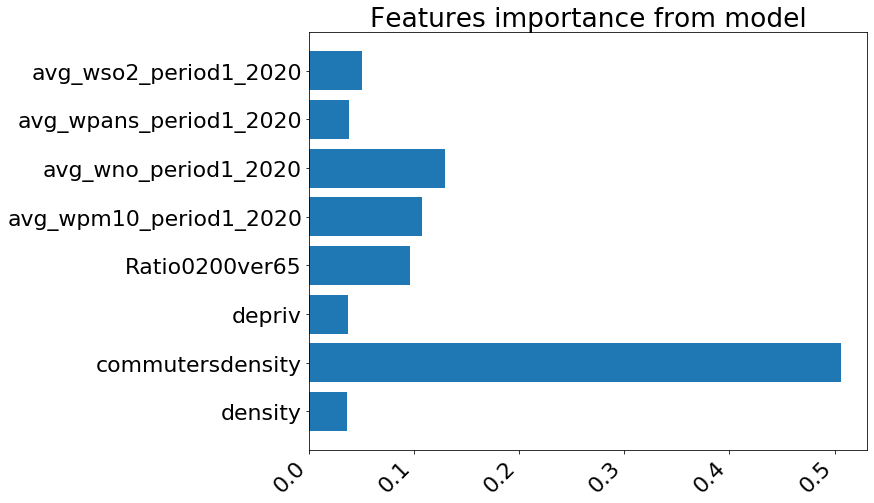

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06700 +/- 0.00821
Feature:               commutersdensity, Score: 1.72785 +/- 0.24180
Feature:                         depriv, Score: 0.08249 +/- 0.00930
Feature:                 Ratio0200ver65, Score: 0.21486 +/- 0.03134
Feature:         avg_wpm10_period1_2020, Score: 0.32370 +/- 0.04305
Feature:           avg_wno_period1_2020, Score: 0.30497 +/- 0.03976
Feature:         avg_wpans_period1_2020, Score: 0.08704 +/- 0.01317
Feature:          avg_wso2_period1_2020, Score: 0.13083 +/- 0.01934


<Figure size 432x288 with 0 Axes>

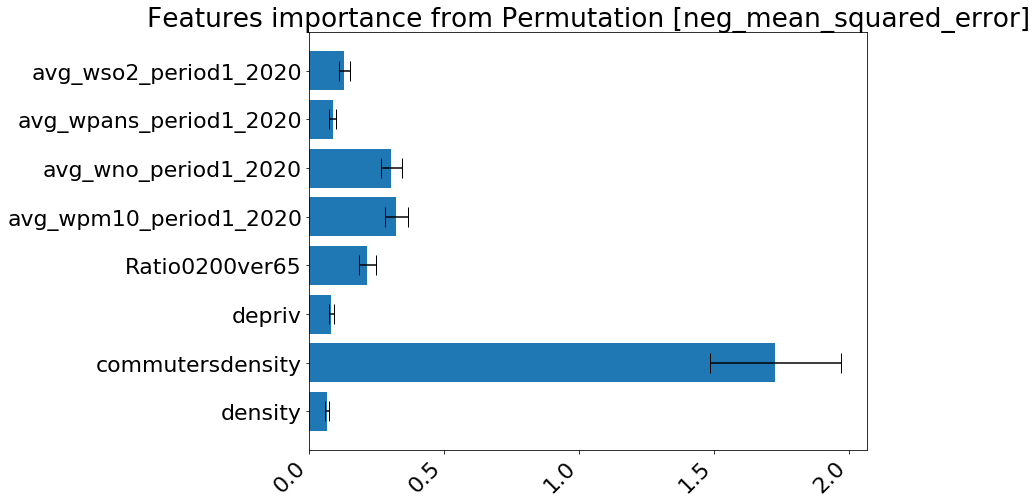

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.03066 +/- 0.00376
Feature:               commutersdensity, Score: 0.79069 +/- 0.11065
Feature:                         depriv, Score: 0.03775 +/- 0.00426
Feature:                 Ratio0200ver65, Score: 0.09832 +/- 0.01434
Feature:         avg_wpm10_period1_2020, Score: 0.14813 +/- 0.01970
Feature:           avg_wno_period1_2020, Score: 0.13956 +/- 0.01819
Feature:         avg_wpans_period1_2020, Score: 0.03983 +/- 0.00603
Feature:          avg_wso2_period1_2020, Score: 0.05987 +/- 0.00885


<Figure size 432x288 with 0 Axes>

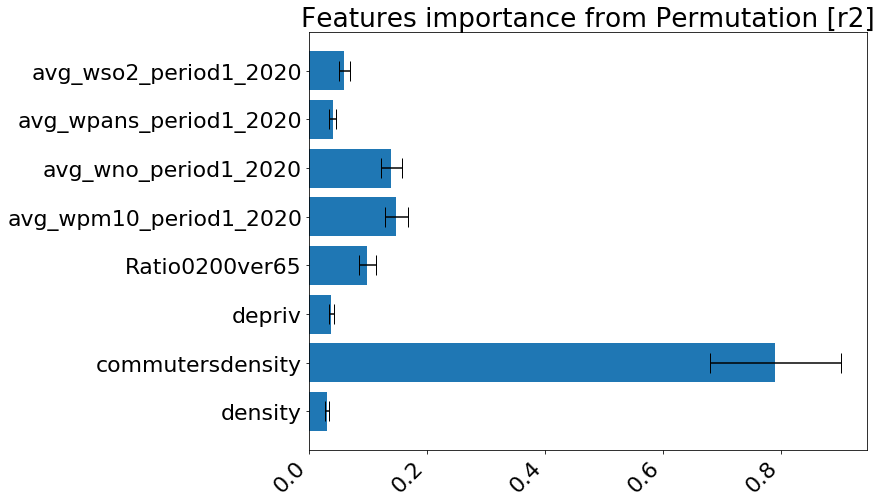

<Figure size 720x720 with 0 Axes>

((0.38850365880724824, 0.02998373640690986),
 (1.0055160324329497, 0.12230856478065684),
 0.35813638639572143,
 {'density': 0.022797361314544014,
  'commutersdensity': 0.587959362138412,
  'depriv': 0.02807016275944631,
  'Ratio0200ver65': 0.07311191765415269,
  'avg_wpm10_period1_2020': 0.11015123849927817,
  'avg_wno_period1_2020': 0.1037752751229318,
  'avg_wpans_period1_2020': 0.029617097847801012,
  'avg_wso2_period1_2020': 0.04451758466343405},
 {'density': 0.02279736131454398,
  'commutersdensity': 0.5879593621384122,
  'depriv': 0.028070162759446283,
  'Ratio0200ver65': 0.07311191765415266,
  'avg_wpm10_period1_2020': 0.11015123849927815,
  'avg_wno_period1_2020': 0.10377527512293178,
  'avg_wpans_period1_2020': 0.029617097847800984,
  'avg_wso2_period1_2020': 0.044517584663434015})

In [8]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat", pout=sys.stdout, showplot=True)

In [9]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.1282616712605855
2  of  1200 MSE:  0.12224857084126077
3  of  1200 MSE:  0.1978055435355346
4  of  1200 MSE:  0.25767024366299246
5  of  1200 MSE:  0.47759972417182905
6  of  1200 MSE:  0.6054081477383956
7  of  1200 MSE:  0.7199083971547234
8  of  1200 MSE:  0.815086270046983
9  of  1200 MSE:  0.18952120328726968
10  of  1200 MSE:  0.21977072640922451
11  of  1200 MSE:  0.22042339758601015
12  of  1200 MSE:  0.28384403154822724
13  of  1200 MSE:  0.47759972417182905
14  of  1200 MSE:  0.6054081477383956
15  of  1200 MSE:  0.7199083971547234
16  of  1200 MSE:  0.815086270046983
17  of  1200 MSE:  0.3164525840114463
18  of  1200 MSE:  0.3875559677615173
19  of  1200 MSE:  0.3390719032378128
20  of  1200 MSE:  0.44440999046963636
21  of  1200 MSE:  0.47759972417182905
22  of  1200 MSE:  0.6054081477383956
23  of  1200 MSE:  0.7199083971547234
24  of  1200 MSE:  0.815086270046983
25  of  1200 MSE:  0.4315242946932369
26  of  1200 MSE:  0.5195687078024055
27  of  1200 M

Training set average RMSE:  0.38001  0.02779 
    Test set average RMSE:  1.02977  0.10174 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.34964
                       R2:  0.94406


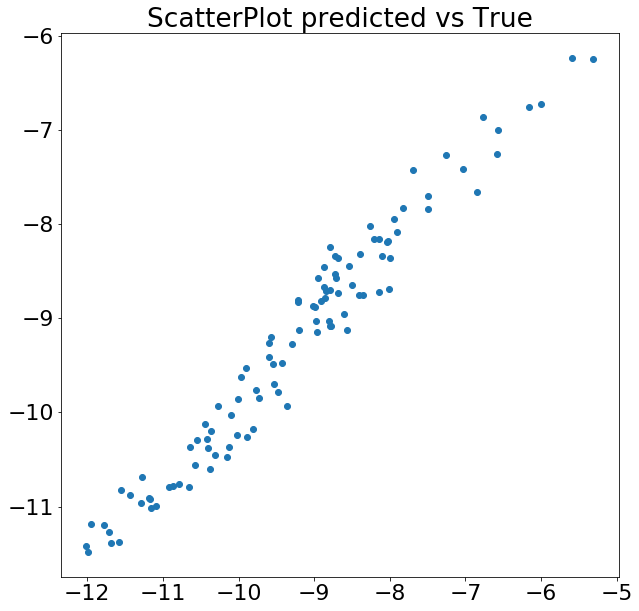

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.05594
Feature:               commutersdensity, Score: 0.21692
Feature:                         depriv, Score: 0.15223
Feature:                 Ratio0200ver65, Score: 0.08214
Feature:         avg_wpm10_period1_2020, Score: 0.16350
Feature:           avg_wno_period1_2020, Score: 0.19565
Feature:         avg_wpans_period1_2020, Score: 0.05142
Feature:          avg_wso2_period1_2020, Score: 0.08220


<Figure size 432x288 with 0 Axes>

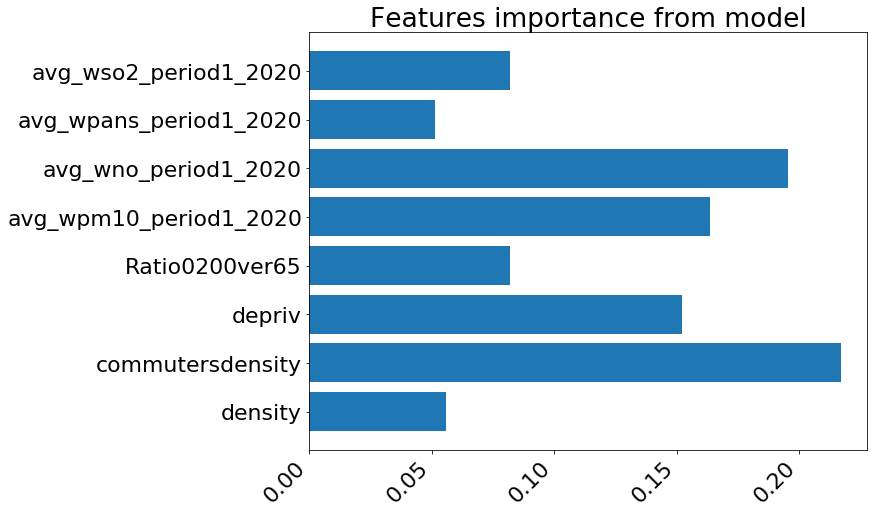

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.06212 +/- 0.00584
Feature:               commutersdensity, Score: 1.75746 +/- 0.25340
Feature:                         depriv, Score: 0.10448 +/- 0.01359
Feature:                 Ratio0200ver65, Score: 0.20991 +/- 0.03119
Feature:         avg_wpm10_period1_2020, Score: 0.29358 +/- 0.03669
Feature:           avg_wno_period1_2020, Score: 0.32578 +/- 0.04270
Feature:         avg_wpans_period1_2020, Score: 0.08167 +/- 0.01015
Feature:          avg_wso2_period1_2020, Score: 0.10296 +/- 0.01630


<Figure size 432x288 with 0 Axes>

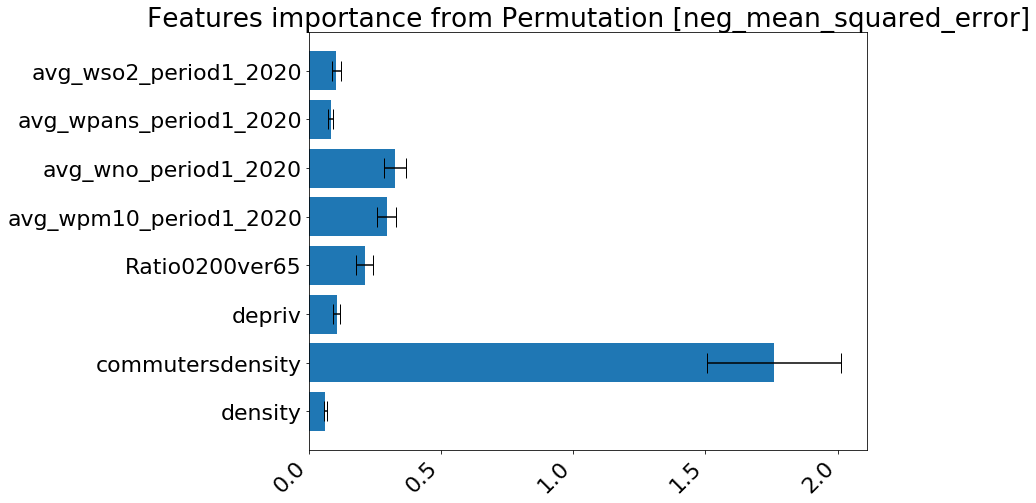

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.02843 +/- 0.00267
Feature:               commutersdensity, Score: 0.80424 +/- 0.11596
Feature:                         depriv, Score: 0.04781 +/- 0.00622
Feature:                 Ratio0200ver65, Score: 0.09606 +/- 0.01427
Feature:         avg_wpm10_period1_2020, Score: 0.13435 +/- 0.01679
Feature:           avg_wno_period1_2020, Score: 0.14908 +/- 0.01954
Feature:         avg_wpans_period1_2020, Score: 0.03737 +/- 0.00465
Feature:          avg_wso2_period1_2020, Score: 0.04712 +/- 0.00746


<Figure size 432x288 with 0 Axes>

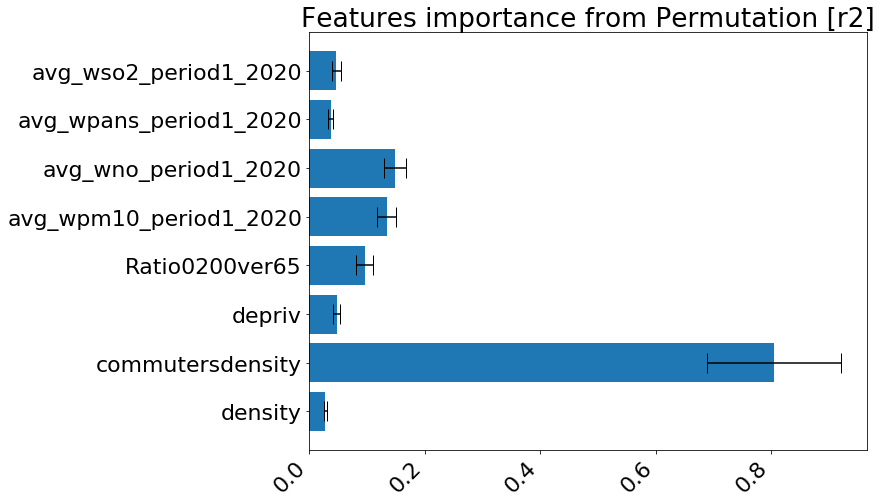

<Figure size 720x720 with 0 Axes>

((0.3800136206422404, 0.027793304902346494),
 (1.0297687772512787, 0.10174307394200745),
 0.34964063099311093,
 {'density': 0.02114523726406306,
  'commutersdensity': 0.5981873902004822,
  'depriv': 0.03556332739929311,
  'Ratio0200ver65': 0.07144778078224327,
  'avg_wpm10_period1_2020': 0.09992758977793331,
  'avg_wno_period1_2020': 0.11088480868022668,
  'avg_wpans_period1_2020': 0.027798026533075795,
  'avg_wso2_period1_2020': 0.0350458393626826},
 {'density': 0.02114523726406308,
  'commutersdensity': 0.598187390200482,
  'depriv': 0.03556332739929313,
  'Ratio0200ver65': 0.07144778078224329,
  'avg_wpm10_period1_2020': 0.09992758977793331,
  'avg_wno_period1_2020': 0.11088480868022667,
  'avg_wpans_period1_2020': 0.027798026533075816,
  'avg_wso2_period1_2020': 0.03504583936268262})

In [10]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_opt", showplot=True, optimisedparams=bestf)

Training set average RMSE:  0.40119  0.02918 
    Test set average RMSE:  1.12949  0.10294 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.38921
                       R2:  0.93068


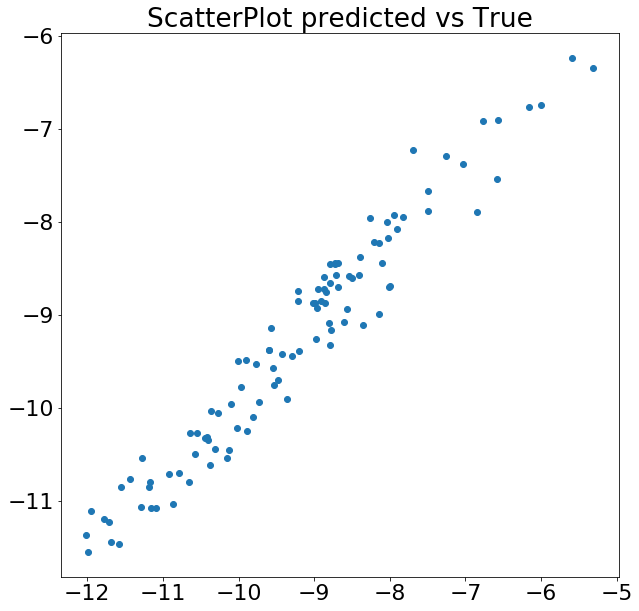

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.03670
Feature:                         depriv, Score: 0.22205
Feature:                 Ratio0200ver65, Score: 0.09486
Feature:         avg_wpm10_period1_2020, Score: 0.19236
Feature:           avg_wno_period1_2020, Score: 0.33260
Feature:         avg_wpans_period1_2020, Score: 0.05858
Feature:          avg_wso2_period1_2020, Score: 0.06284


<Figure size 432x288 with 0 Axes>

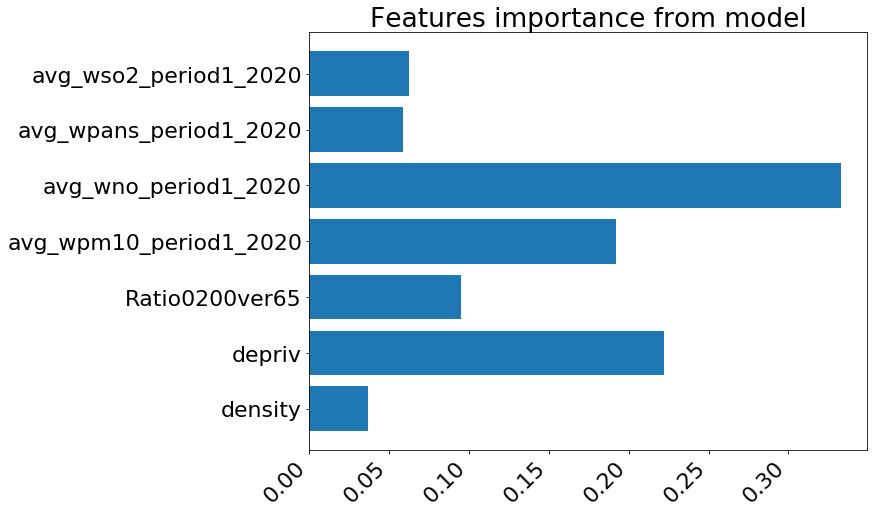

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.08093 +/- 0.00990
Feature:                         depriv, Score: 0.71240 +/- 0.09629
Feature:                 Ratio0200ver65, Score: 0.21869 +/- 0.03247
Feature:         avg_wpm10_period1_2020, Score: 0.36664 +/- 0.04913
Feature:           avg_wno_period1_2020, Score: 0.93008 +/- 0.12349
Feature:         avg_wpans_period1_2020, Score: 0.16339 +/- 0.02158
Feature:          avg_wso2_period1_2020, Score: 0.10520 +/- 0.01133


<Figure size 432x288 with 0 Axes>

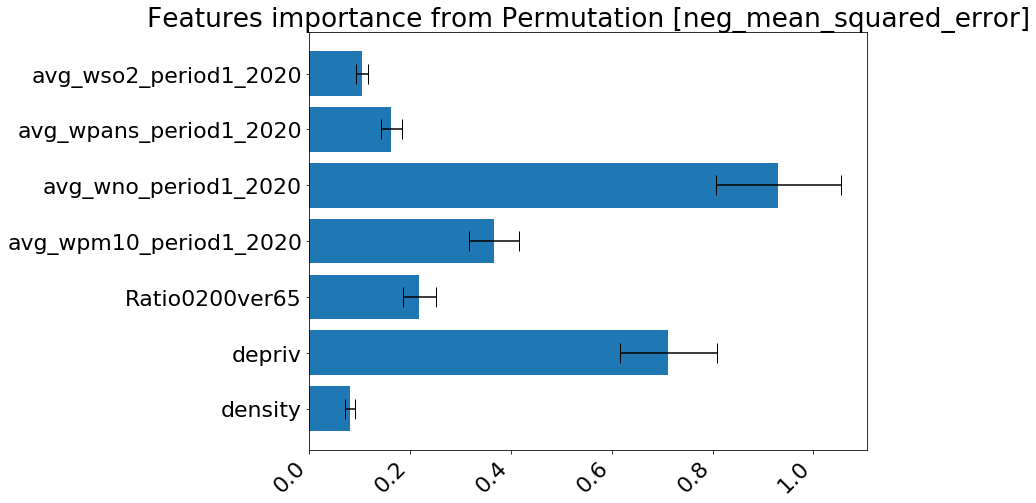

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.03703 +/- 0.00453
Feature:                         depriv, Score: 0.32600 +/- 0.04407
Feature:                 Ratio0200ver65, Score: 0.10007 +/- 0.01486
Feature:         avg_wpm10_period1_2020, Score: 0.16778 +/- 0.02248
Feature:           avg_wno_period1_2020, Score: 0.42562 +/- 0.05651
Feature:         avg_wpans_period1_2020, Score: 0.07477 +/- 0.00987
Feature:          avg_wso2_period1_2020, Score: 0.04814 +/- 0.00519


<Figure size 432x288 with 0 Axes>

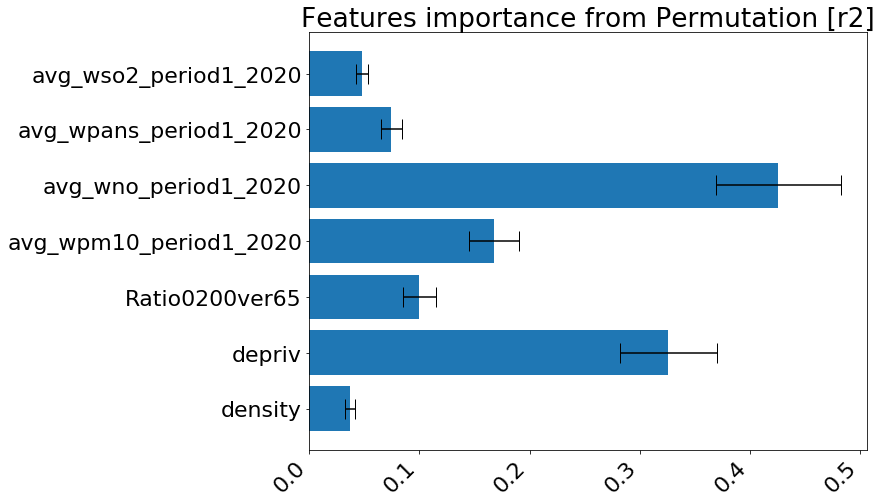

<Figure size 720x720 with 0 Axes>

((0.40119046901099564, 0.02918007834475281),
 (1.1294859379178532, 0.10293800269434668),
 0.3892097210503831,
 {'density': 0.031399076495752944,
  'depriv': 0.276409151341883,
  'Ratio0200ver65': 0.08484998961879976,
  'avg_wpm10_period1_2020': 0.14225650850652505,
  'avg_wno_period1_2020': 0.3608705167668594,
  'avg_wpans_period1_2020': 0.06339668950651364,
  'avg_wso2_period1_2020': 0.04081806776366621},
 {'density': 0.03139907649575293,
  'depriv': 0.27640915134188293,
  'Ratio0200ver65': 0.08484998961879973,
  'avg_wpm10_period1_2020': 0.14225650850652502,
  'avg_wno_period1_2020': 0.3608705167668594,
  'avg_wpans_period1_2020': 0.06339668950651364,
  'avg_wso2_period1_2020': 0.04081806776366619})

In [11]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, plotname="rf_model_nolat_nocommut", pout=sys.stdout, showplot=True)

In [12]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack(listostack)
Y = np.asanyarray(ylogpropcasi)

bestf, bestmse = smlmodule.rfregressors_custom_optimizer (X, Y, inboot=[True])

print(bestf, bestmse)

1  of  1200 MSE:  0.15148420696011702
2  of  1200 MSE:  0.13437573810645206
3  of  1200 MSE:  0.2280046689962787
4  of  1200 MSE:  0.27879027174186277
5  of  1200 MSE:  0.5512564730750242
6  of  1200 MSE:  0.6382504684741939
7  of  1200 MSE:  0.8641463004337666
8  of  1200 MSE:  0.9202233163150013
9  of  1200 MSE:  0.21422836959226566
10  of  1200 MSE:  0.25163641129818315
11  of  1200 MSE:  0.255998292919161
12  of  1200 MSE:  0.31458901898628394
13  of  1200 MSE:  0.5512564730750242
14  of  1200 MSE:  0.6382504684741939
15  of  1200 MSE:  0.8641463004337666
16  of  1200 MSE:  0.9202233163150013
17  of  1200 MSE:  0.346321012589264
18  of  1200 MSE:  0.4125608550254297
19  of  1200 MSE:  0.38598736036531744
20  of  1200 MSE:  0.44612170576391463
21  of  1200 MSE:  0.5512564730750242
22  of  1200 MSE:  0.6382504684741939
23  of  1200 MSE:  0.8641463004337666
24  of  1200 MSE:  0.9202233163150013
25  of  1200 MSE:  0.4870945186144851
26  of  1200 MSE:  0.5559307709024451
27  of  1200 MS

Training set average RMSE:  0.40343  0.02867 
    Test set average RMSE:  1.05668  0.12217 
Parameters used: 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}
             Fullset RMSE:  0.36612
                       R2:  0.93866


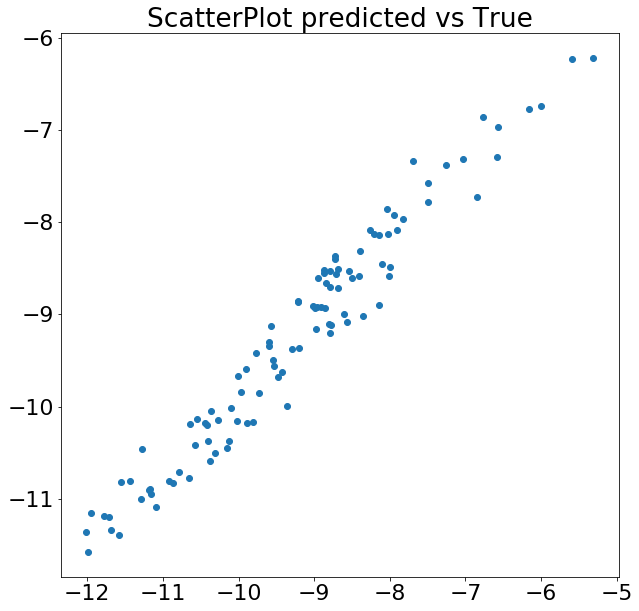

<Figure size 720x720 with 0 Axes>


Features importance from model: 
Feature:                        density, Score: 0.08228
Feature:                         depriv, Score: 0.19326
Feature:                 Ratio0200ver65, Score: 0.09927
Feature:         avg_wpm10_period1_2020, Score: 0.19816
Feature:           avg_wno_period1_2020, Score: 0.25315
Feature:         avg_wpans_period1_2020, Score: 0.07002
Feature:          avg_wso2_period1_2020, Score: 0.10386


<Figure size 432x288 with 0 Axes>

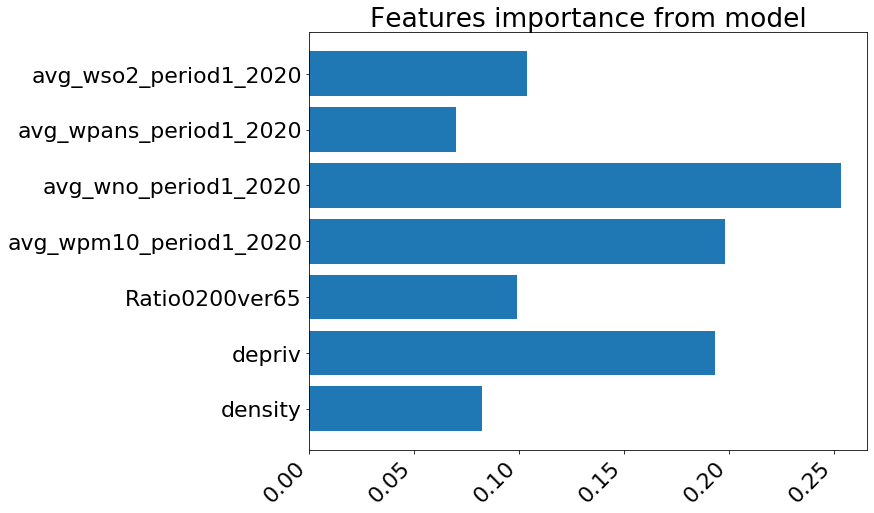

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score neg_mean_squared_error : 
Feature:                        density, Score: 0.07636 +/- 0.01019
Feature:                         depriv, Score: 0.63265 +/- 0.08207
Feature:                 Ratio0200ver65, Score: 0.21695 +/- 0.03030
Feature:         avg_wpm10_period1_2020, Score: 0.39608 +/- 0.05669
Feature:           avg_wno_period1_2020, Score: 0.96597 +/- 0.13002
Feature:         avg_wpans_period1_2020, Score: 0.14527 +/- 0.02107
Feature:          avg_wso2_period1_2020, Score: 0.13007 +/- 0.01496


<Figure size 432x288 with 0 Axes>

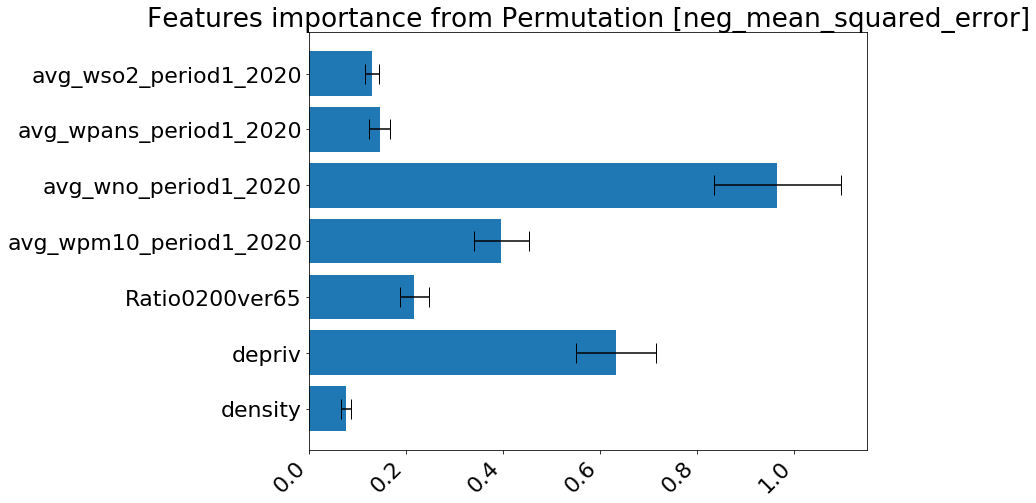

<Figure size 720x720 with 0 Axes>


Features importance from Permutation Score r2: 
Feature:                        density, Score: 0.03494 +/- 0.00466
Feature:                         depriv, Score: 0.28951 +/- 0.03755
Feature:                 Ratio0200ver65, Score: 0.09928 +/- 0.01387
Feature:         avg_wpm10_period1_2020, Score: 0.18125 +/- 0.02594
Feature:           avg_wno_period1_2020, Score: 0.44204 +/- 0.05950
Feature:         avg_wpans_period1_2020, Score: 0.06648 +/- 0.00964
Feature:          avg_wso2_period1_2020, Score: 0.05952 +/- 0.00684


<Figure size 432x288 with 0 Axes>

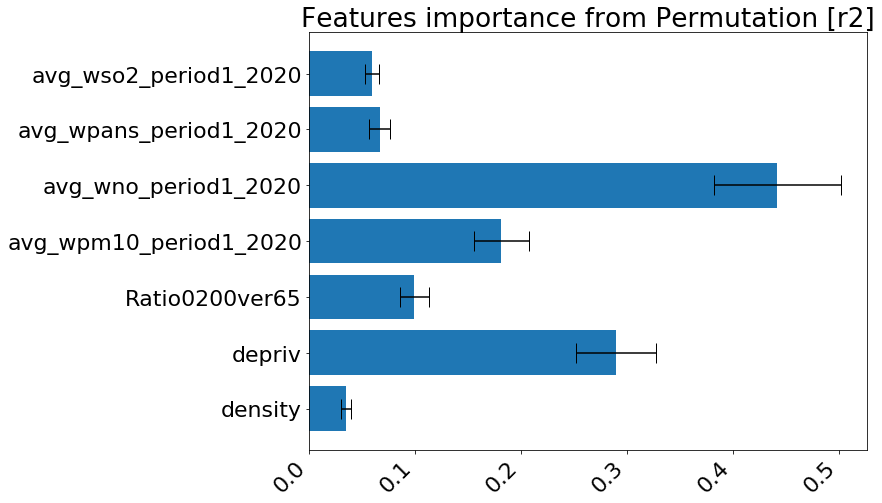

<Figure size 720x720 with 0 Axes>

((0.40343011520441074, 0.028672909449238438),
 (1.0566755044876663, 0.12217102736443365),
 0.36611875261389626,
 {'density': 0.029789925800943102,
  'depriv': 0.24680537313633266,
  'Ratio0200ver65': 0.08463490891139108,
  'avg_wpm10_period1_2020': 0.15451712967349845,
  'avg_wno_period1_2020': 0.37683674538528755,
  'avg_wpans_period1_2020': 0.0566733033453356,
  'avg_wso2_period1_2020': 0.05074261374721152},
 {'density': 0.029789925800943116,
  'depriv': 0.24680537313633266,
  'Ratio0200ver65': 0.0846349089113911,
  'avg_wpm10_period1_2020': 0.15451712967349845,
  'avg_wno_period1_2020': 0.3768367453852876,
  'avg_wpans_period1_2020': 0.0566733033453356,
  'avg_wso2_period1_2020': 0.05074261374721153})

In [13]:
importlib.reload(smlmodule)

featuresused = []

for f in features:
    if f != "lat" and f != "commutersdensity":
        featuresused.append(f)

listostack = [features_dict[v] for v in featuresused]

X = np.column_stack (listostack)
Y = np.asanyarray(ylogpropcasi)

plt.figure(figsize=(10,10))
smlmodule.rfregressors (X, Y , featuresused, N=50, pout=sys.stdout, plotname="rf_model_nolat_nocommut_opt", showplot=True, optimisedparams=bestf)